In [1]:
# Data
import numpy as np

# if __name__ == '__main__':
with open('data/text_data/japan.txt', 'r') as f:
    txt = f.read()

    X = []
    y = []

    char_to_idx = {char: i for i, char in enumerate(set(txt))}
    idx_to_char = {i: char for i, char in enumerate(set(txt))}
    
    X = [char_to_idx[x] for x in txt]
    X = np.array(X)
    y = [char_to_idx[x] for x in txt[1:]]
    y.append(char_to_idx['.'])
    y = np.array(y)

# # Data exploration
# X.shape, y.shape, X, y, txt.split()[:2], 
# # set(txt), 
# # for val, key in enumerate(set(txt)):
# #     print(val, key)
# val2char = {val: key for val, key in enumerate(set(txt))}
# # val2char

In [2]:
# Model
import impl.layer as l

class RNN:

    def __init__(self, D, H, L, char2idx, idx2char, p_dropout):
        self.D = D
        self.H = H
        self.L = L
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.vocab_size = len(char2idx)
        self.losses = {'train':[], 'train2':[]}
        self.p_dropout = p_dropout
        
        # model parameters
        m = dict(
            Wxh=np.random.randn(D, H) / np.sqrt(D / 2.),
            Whh=np.random.randn(H, H) / np.sqrt(H / 2.),
            Why=np.random.randn(H, D) / np.sqrt(H / 2.),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
            )
        self.model = []
        for _ in range(self.L):
            self.model.append(m)
            
    def initial_state(self):
        return np.zeros((1, self.H))

    def forward(self, X, h, m):
        Wxh, Whh, Why = m['Wxh'], m['Whh'], m['Why']
        bh, by = m['bh'], m['by']

        hprev = h.copy()
    
        h = (X @ Wxh) + (hprev @ Whh) + bh
        h, h_cache = l.tanh_forward(h)

        y, y_cache = l.fc_forward(h, Why, by)
        y, nl_cache = self.selu_forward(y)
        y, do_cache = self.alpha_dropout_fwd(h=y, q=1.0-self.p_dropout) # q=1-p, 1=keep_prob
        #         y, do_cache = self.dropout_forward(X=y, p_dropout=self.p_dropout)

        cache = (X, hprev, Wxh, Whh, h_cache, y_cache, nl_cache, do_cache)

        return y, h, cache

    def backward(self, dy, dh, cache):
        X, hprev, Wxh, Whh, h_cache, y_cache, nl_cache, do_cache = cache

        dh_next = dh.copy()
        
        #         dy = self.dropout_backward(dout=dy, cache=do_cache)
        dy = self.alpha_dropout_bwd(dout=dy, cache=do_cache)
        dy = self.selu_backward(dy, nl_cache)
        dh, dWhy, dby = l.fc_backward(dy, y_cache)
        dh += dh_next
        dby = dby.reshape((1, -1))

        dh = l.tanh_backward(dh, h_cache)
        dbh = dh * 1.0
        dWhh = hprev.T @ dh
        dWxh = X.T @ dh
        dX = dh @ Wxh.T
        dh = dh @ Whh.T

        grad = dict(Wxh=dWxh, Whh=dWhh, Why=dWhy, bh=dbh, by=dby)
        
        return dX, dh, grad

    # keep_prob = 1 - p_dropout, q = 1 - p
    def dropout_forward(self, X, p_dropout):
        u = np.random.binomial(1, p_dropout, size=X.shape) / p_dropout
        out = X * u
        cache = u
        return out, cache

    def dropout_backward(self, dout, cache):
        u = cache
        dX = dout * u
        return dX

    def selu_forward(self, X):
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
        out = scale * np.where(X>=0.0, X, alpha * (np.exp(X)-1))
        cache = X
        return out, cache

    def selu_backward(self, dout, cache):
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
        X = cache
        dX_pos = dout.copy()
        dX_pos[X<0] = 0
        dX_neg = dout.copy()
        dX_neg[X>0] = 0
        dX = scale * np.where(X>=0.0, dX_pos, dX_neg * alpha * np.exp(X))
        return dX
    
    def alpha_dropout_fwd(self, h, q):
        '''h is activation, q is keep probability: q=1-p, p=p_dropout, and q=keep_prob'''
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
        alpha_p = -scale * alpha
        mask = np.random.binomial(1, q, size=h.shape)
        dropped = mask * h + (1 - mask) * alpha_p
        a = 1. / np.sqrt(q + alpha_p ** 2 * q  * (1 - q))
        b = -a * (1 - q) * alpha_p
        out = a * dropped + b
        cache = (a, mask)
        return out, cache

    def alpha_dropout_bwd(self, dout, cache):
        a, mask = cache
        d_dropped = dout * a
        dh = d_dropped * mask
        return dh
    
    def train_forward(self, X_train, h):
        ys, caches = [], []
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())
            caches.append([])
            
        for X in X_train:
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.0
            y = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], cache = self.forward(y, h[layer], self.model[layer])
                caches[layer].append(cache)
                
            ys.append(y)
            
        return ys, caches
    
    def cross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        prob = l.softmax(y_pred)
        log_like = -np.log(prob[range(m), y_train])
        data_loss = np.sum(log_like) / m

        return data_loss

    def dcross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        grad_y = l.softmax(y_pred)
        grad_y[range(m), y_train] -= 1.0
        grad_y /= m

        return grad_y


    def loss_function(self, y_train, ys):
        loss, dys = 0.0, []

        for y_pred, y in zip(ys, y_train):
            loss += self.cross_entropy(y_pred, y)/ y_train.shape[0]
            dy = self.dcross_entropy(y_pred, y)
            dys.append(dy)
            
        return loss, dys

    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        for layer in range(self.L):
            dh.append(np.zeros((1, self.H)))
            grad.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            grads.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})

        for t in reversed(range(len(dys))):
            dX = dys[t]
            for layer in reversed(range(self.L)):
                dX, dh[layer], grad[layer] = self.backward(dX, dh[layer], caches[layer][t])
                for k in grad[0].keys():
                    grads[layer][k] += grad[layer][k]
                
        return dX, grads
    
    def test(self, X_seed, h, size):
        chars = [self.idx2char[X_seed]]
        idx_list = list(range(self.vocab_size))
        X = X_seed
        
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())

        for _ in range(size): # range(start, stop, step)
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.0
            y = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], _ = self.forward(y, h[layer], self.model[layer])
                
            prob = l.softmax(y)
            idx = np.random.choice(idx_list, p=prob.ravel())
            chars.append(self.idx2char[idx])
            X = idx

        return ''.join(chars)

In [3]:
from sklearn.utils import shuffle as skshuffle

def get_minibatch(X, y, minibatch_size, shuffle=True):
    minibatches = []

    if shuffle:
        X, y = skshuffle(X, y)

    for i in range(0, X.shape[0], minibatch_size):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]
        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, X_train, y_train, alpha, mb_size, n_iter, print_after):
    minibatches = get_minibatch(X_train, y_train, mb_size, shuffle=False)

    M, R = [], []
    for layer in range(nn.L):
        M.append({key: np.zeros_like(val) for key, val in nn.model[layer].items()}) # dict={items, key:val, word:ID}
        R.append({key: np.zeros_like(val) for key, val in nn.model[layer].items()})
        
    beta1 = .99 # 0.9 to 0.99
    beta2 = .999
    state = nn.initial_state()
    
    #     import impl.constant as c, c.eps
    eps = 1e-8 # constant

    # Epochs
    for iter in range(1, n_iter + 1): # range(start, stop, step=1 by default)

        # No batches or other files available
        # Minibatches
        for idx in range(len(minibatches)):
            X_mini, y_mini = minibatches[idx]
            ys, caches = nn.train_forward(X_mini, state)
            loss, dys = nn.loss_function(y_mini, ys)
            dX, grads = nn.train_backward(dys, caches)
            nn.losses['train'].append(loss)

            for layer in range(nn.L):
                for key in grads[layer].keys(): #key, value: items for dict={}
                    M[layer][key] = l.exp_running_avg(M[layer][key], grads[layer][key], beta1)
                    R[layer][key] = l.exp_running_avg(R[layer][key], grads[layer][key]**2, beta2)

                    m_k_hat = M[layer][key] / (1. - (beta1**(iter)))
                    r_k_hat = R[layer][key] / (1. - (beta2**(iter)))

                    nn.model[layer][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + eps)
                
        # Print training loss and predicted samping for testing the model
        if iter % print_after == 0:
            print('Iter-{} training loss: {:.4f}'.format(iter, loss))
            sample = nn.test(X_mini[0], state, size=100)
            print(sample)
    
    return nn

In [6]:
# hyper-parameters
n_iter = 1300 # epochs
print_after = n_iter//10 # print loss, valid, and test
time_step = 100 # width
alpha = 1/time_step #1e-3 # learning_rate
num_layers = 1 # depth
num_hidden_units = 64 # hidden layer
num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)
p_dropout = 0.05 # keep_prob=1.0-p_dropout, q=1-p, 5% to 10% noise is recommanded for p_dropout

net = RNN(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char, 
          p_dropout=p_dropout)

adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

Iter-130 training loss: 2.6361
er 1cheLestinafe"py co; ttKarat4Dpre In the Pea 30e", me9uan
. as a 1d inat annsio1tP the eaghteaturo
Iter-260 training loss: 2.5249
e% RunoStary po(Pua4, fiin; B2rJapan7 puJepul aleex,TSKaPeDesslrtcich 日wh MeA.ce日0tEcore cnr8ce
. Gnc
Iter-390 training loss: 2.5969
er FraranRy aneslPore8t inRy cojunte 2
5 no6 ale laoJapan, ewe of theLuro-Japao dony % of to Wur vike
Iter-520 training loss: 2.4808
e Horla日 the wor indd Japandd 3ded 0th thc it–overtzt can"med liry zhe wery. heChed Lo) worleD-la5FtK
Iter-650 training loss: 2.8038
er9Brandec本 viche lal 4:s the Cheihen the Inch'stE the hisheatFtTd in, the Japwttare Runnondopucon6 o
Iter-780 training loss: 2.2964
e  or xan The AstoncederMel turies was bHl cipd 'ipby Chison ymplato the countamEacla
.urhorellarLy 9
Iter-910 training loss: 2.4829
ed fchGly:ciy te mipin Pon r) of es is –jedtceaUd coterMely. in of Japis cojocinod ron aler eiawzher 
Iter-1040 training loss: 2.2424
erporth thirdonted In(, ) TheAped, in

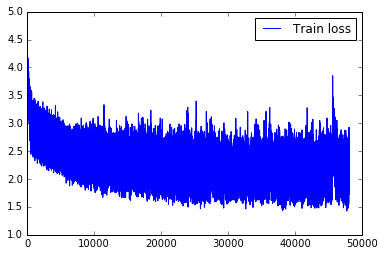

In [7]:
# Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
# plt.plot(net.losses['train2'], label='Train loss 2')
plt.legend()
plt.show()